## Importing Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time


## Signal Data Generation
Creating a composite signal made up of three sine waves. The signal is sampled at a specific rate and is ready for performing an FFT.

In [2]:
N=8192
T=1
f1=200
f2=300
f3=400
t=np.linspace(0,T,N)
freq=np.fft.fftfreq(N*T,1/N)
data=400*np.sin(2*np.pi*f1*t,dtype=np.csingle)+200*np.sin(2*np.pi*f2*t,dtype=np.csingle)+50*np.sin(2*np.pi*f3*t,dtype=np.csingle)

## Performing FFT Using NumPy

In [3]:
%%time
dft=np.fft.fft(data)

CPU times: user 3.57 ms, sys: 0 ns, total: 3.57 ms
Wall time: 2.77 ms


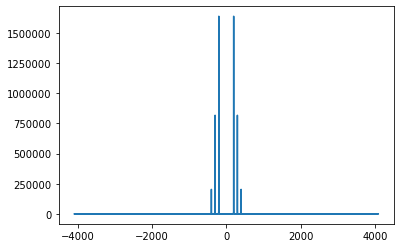

In [4]:
plt.plot(freq,np.abs(dft))

## Loading PYNQ Overlay and Setting Up DMA Channels
Loading the custom FPGA configuration (bitstream) for FFT processing and sets up the DMA channels. These channels will be used to transfer data between the CPU and FPGA efficiently.

In [5]:
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
# Load the overlay
ol = Overlay("fft.bit")
# Load the FIR DMA
data_dma = ol.fft.data_dma
config_dma = ol.fft.config_dma

data_send=data_dma.sendchannel
data_recv=data_dma.recvchannel
config_send=config_dma.sendchannel

## Configuring the FFT IP Core

![image](./config.JPG)

- In PAD area ,padding is done, 0 is added there
- We don't need CP_LEN, so all 0
- FWD/INV is to select what operation to perform, Normal FFT or Inverse FFT
- NFFT is to select the FFT Size, eg if N=1024(2^10), so we need to set it to 10(1010)

In [6]:
from math import log
def config(op,size):

    cplen='0'*8

    x=int(log(size,2))
    x_bin=bin(x)[2:]
    
    tdata=op.zfill(8)+cplen+x_bin.zfill(8)
    return int(tdata,2)


## Passing the Configuration Data
Allocating the memory buffer for configuration data and passing it to the FFT IP:

In [7]:
config_buffer =allocate(1,np.uint32)
config_buffer[0]=config('1',N)

In [8]:
config_send.transfer(config_buffer)

## Hardware-Accelerated FFT Execution
Allocating memory buffers for input and output and further performing FFT using Hardware:

In [9]:
data_buffer = allocate(N,np.csingle)
out_buffer = allocate(N,np.csingle)
np.copyto (data_buffer, data)

In [10]:
%%time
data_send.transfer(data_buffer)
data_recv.transfer (out_buffer)

CPU times: user 688 µs, sys: 0 ns, total: 688 µs
Wall time: 643 µs


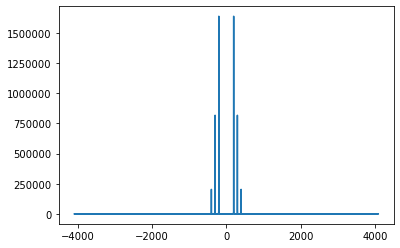

In [11]:
plt.plot(freq,np.abs(out_buffer))

## Cleaning Up

In [12]:
del config_buffer
del data_buffer
del out_buffer